In [ ]:
import sys
sys.path.append('../core')
sys.path.append('/packing/code/core/')

import pack_runner
import pack_ga3
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dill
import importlib
from multiprocess import Process, Queue, cpu_count
import kaggle_support as kgs
importlib.reload(pack_runner)

# Configuration
output_dir = '../../results/many_ga/'
os.makedirs(output_dir + 'full/', exist_ok=True)
os.makedirs(output_dir + 'abbr/', exist_ok=True)

fast_mode = True  # Set to True for quick testing
which_runner = pack_runner.baseline_runner  # Which example runner to use
n_parallel_processes = 4 if kgs.env=='local' else 4
print(f"Will use {n_parallel_processes} parallel processes")

local
Will use 4 parallel processes


In [2]:
# Get git commit ID for tracking
try:
    import git
    repo = git.Repo(search_parent_directories=True)
    git_commit_id = repo.head.object.hexsha
    print(f"Git commit: {git_commit_id[:8]}")
except:
    git_commit_id = 'no_git'
    print("Git not available, using 'no_git' as commit ID")

Git commit: 9c8f147f


In [3]:
%load_ext pyinstrument

In [ ]:
import kaggle_support as kgs
kgs.profiling = False

def run_single_seed(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue):
    """Worker function to run a single seed in a separate process"""
    # Import everything needed in this worker process
    import sys
    sys.path.append('../core')
    sys.path.append('/packing/code/core/')
    
    import numpy as np
    import time
    import copy
    import os
    import dill
    
    try:
        # Set CUDA device based on process to avoid conflicts
        # This helps if you have multiple GPUs
        try:
            import cupy as cp
            # Use modulo to cycle through available GPUs
            n_gpus = cp.cuda.runtime.getDeviceCount()
            device_id = seed % n_gpus
            cp.cuda.Device(device_id).use()
            # Small delay to stagger CUDA initialization
            time.sleep(0.5)
            print(f'Seed {seed} using GPU {device_id}')
        except Exception as e:
            print(f'Warning: Could not set CUDA device for seed {seed}: {e}')
        
        print(f'\n=== Starting seed {seed} (Process {os.getpid()}) ===')
        
        r = which_runner(fast_mode=fast_mode)
        r.seed = seed
        r.base_ga.ga.N_trees_to_do = 40
        
        # Check if this experiment already exists
        base_filename = f"{r.label}_{r.seed}_{git_commit_id[:8]}"
        if fast_mode:
            base_filename += '_fast'
        
        # Run the experiment
        start_time = time.time()
        r.run()
        elapsed_time = time.time() - start_time
        
        if r.exception is not None:
            print(f"ERROR occurred in seed {seed}: {r.exception[:200]}")
            result_queue.put({'seed': seed, 'success': False, 'error': r.exception[:200]})
            return
        
        # Get best costs for each configuration (tree sizes, etc.)
        # r.best_costs is now shape (n_generations, n_configs) from pack_ga2 structure
        best_costs_final = r.best_costs[-1, :]
        print(f"\nSeed {seed} completed in {elapsed_time:.1f}s")
        print(f"Best final costs: {best_costs_final}")
        print(f"Modifier values: {r.modifier_values}")
        
        # Create score string from average best cost
        avg_cost = np.mean(best_costs_final)
        score_str = f"{avg_cost:.4f}".replace('.', '_')
        
        # Save full version (with populations)
        output_file_full = output_dir + 'full/' + base_filename + '_f.pkl'
        with open(output_file_full, 'wb') as f:
            dill.dump(r, f)
        print(f"Saved full: {output_file_full}")
        
        # Save abbreviated version (without populations to save space)
        r_abbr = copy.deepcopy(r)
        #r_abbr.result_ga.ga.champions = []  # Clear champions to save space
        r_abbr.result_ga.ga.abbreviate()
        output_file_abbr = output_dir + 'abbr/' + base_filename + '_a.pkl'
        with open(output_file_abbr, 'wb') as f:
            dill.dump(r_abbr, f)
        print(f"Saved abbr: {output_file_abbr}")
        
        # Put result data in queue for plotting
        result_queue.put({
            'seed': seed,
            'success': True,
            'label': r.label,
            'best_costs': r.best_costs.copy(),
            'n_configs': r.best_costs.shape[1],  # Number of configurations (tree sizes, etc.)
            'avg_cost': avg_cost,
            'elapsed_time': elapsed_time
        })
        
        print(f"Seed {seed} finished successfully!")
        print(f"{'='*60}")
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        print(f"EXCEPTION in seed {seed}:\n{error_msg}")
        result_queue.put({'seed': seed, 'success': False, 'error': str(e)})


# Main parallel execution
n_seeds = 1000 if not fast_mode else 4
result_queue = Queue()
active_processes = []
completed_results = []
seeds_to_run = [a+0 for a in list(range(n_seeds))]
next_seed_idx = 0

# Limit parallel processes if using GPU (to avoid memory issues)
# You may want to adjust this based on your GPU memory
import cupy as cp
n_gpus = cp.cuda.runtime.getDeviceCount()
print(f"Detected {n_gpus} GPU(s)")

# Adjust parallel processes - too many can overwhelm GPU memory
# Start with 1-2 processes per GPU, adjust based on your GPU memory
max_parallel = n_parallel_processes
print(f"Starting parallel execution of {n_seeds} seeds using {max_parallel} processes")
print(f"Staggering process startup by 2 seconds each...\n")

# Start initial batch of processes with staggered startup
stagger_delay = 5.0  # seconds between each process start
for i in range(min(max_parallel, n_seeds)):
    seed = seeds_to_run[next_seed_idx]
    print(f"Starting process for seed {seed}...")
    p = Process(target=run_single_seed, args=(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
    p.start()
    active_processes.append((p, seed))
    next_seed_idx += 1
    
    # Stagger the startup to avoid CUDA initialization conflicts
    if i < min(max_parallel, n_seeds) - 1:  # Don't sleep after the last one
        time.sleep(stagger_delay)

print(f"\nAll initial processes started. Monitoring for completion...\n")

# Track when we last started a process to stagger new starts
last_process_start_time = time.time()

# Main loop: wait for processes to complete and start new ones
while active_processes or not result_queue.empty():
    # Check for completed results in queue
    while not result_queue.empty():
        result = result_queue.get()
        completed_results.append(result)
        
        if result['success']:
            print(f"\n*** Result received for seed {result['seed']}: avg_cost = {result['avg_cost']:.6f}, time = {result['elapsed_time']:.1f}s ***\n")
            
            # Plot convergence for this seed immediately
            fig, ax = plt.subplots(figsize=(10, 6))
            for i_config in range(result['n_configs']):
                ax.plot(result['best_costs'][:, i_config], label=f'Config {i_config}')
            ax.set_xlabel('Generation')
            ax.set_ylabel('Best Cost')
            ax.set_title(f"Seed {result['seed']} - Final cost: {result['avg_cost']:.6f} (Time: {result['elapsed_time']:.1f}s)")
            ax.legend()
            ax.grid(True)
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"\n*** Seed {result['seed']} failed: {result.get('error', 'Unknown error')} ***\n")
    
    # Check for finished processes and start new ones
    for i in range(len(active_processes) - 1, -1, -1):
        p, seed = active_processes[i]
        if not p.is_alive():
            p.join()
            active_processes.pop(i)
            
            # Start a new process if there are more seeds to run
            if next_seed_idx < n_seeds:
                new_seed = seeds_to_run[next_seed_idx]
                
                # Stagger new process starts to avoid CUDA conflicts
                time_since_last_start = time.time() - last_process_start_time
                if time_since_last_start < stagger_delay:
                    sleep_time = stagger_delay - time_since_last_start
                    print(f"Waiting {sleep_time:.1f}s before starting seed {new_seed}...")
                    time.sleep(sleep_time)
                
                print(f"Starting process for seed {new_seed}...")
                new_p = Process(target=run_single_seed, args=(new_seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
                new_p.start()
                active_processes.append((new_p, new_seed))
                last_process_start_time = time.time()
                next_seed_idx += 1
    
    # Small sleep to avoid busy waiting
    time.sleep(0.1)

print(f"\n{'='*80}")
print(f"All {n_seeds} seeds completed!")
print(f"Successful runs: {sum(1 for r in completed_results if r['success'])}")
print(f"Failed runs: {sum(1 for r in completed_results if not r['success'])}")

# Create summary plots for all successful runs
successful_results = [r for r in completed_results if r['success']]
if successful_results:
    print(f"\nCreating summary plots for {len(successful_results)} successful runs...")
    
    # Plot all convergence curves overlaid
    fig, ax = plt.subplots(figsize=(12, 8))
    for result in successful_results:
        for i_config in range(result['n_configs']):
            ax.plot(result['best_costs'][:, i_config], alpha=0.3, linewidth=0.5, color='blue')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Cost')
    ax.set_title(f'GA Convergence - All {len(successful_results)} Runs (Overlaid)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot distribution of final costs
    final_costs = [r['avg_cost'] for r in successful_results]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(final_costs, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(final_costs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(final_costs):.6f}')
    ax.axvline(np.min(final_costs), color='green', linestyle='--', linewidth=2, label=f'Best: {np.min(final_costs):.6f}')
    ax.set_xlabel('Average Final Cost')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Final Costs ({len(successful_results)} runs)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Statistics:")
    print(f"  Best cost:  {np.min(final_costs):.6f}")
    print(f"  Worst cost: {np.max(final_costs):.6f}")
    print(f"  Mean cost:  {np.mean(final_costs):.6f}")
    print(f"  Std cost:   {np.std(final_costs):.6f}")
    print(f"  Median cost: {np.median(final_costs):.6f}")


Detected 1 GPU(s)
Starting parallel execution of 1000 seeds using 4 processes
Staggering process startup by 2 seconds each...

Starting process for seed 0...
local
Seed 0 using GPU 0

=== Starting seed 0 (Process 12300) ===
{'seed': 0, 'champion_fraction': 0.14554425309821817, 'tournament_size': 4, 'selection_fraction': 0.31638940957447786}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function p

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0: Best costs = [[3.857979, 0.091075]]
Starting process for seed 2...
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    1264 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 78 register

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Starting process for seed 3...

All initial processes started. Monitoring for completion...

Generation 4: Best costs = [[3.857979, 0.014204]]
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    1264 bytes stack frame, 0 bytes spil

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 6: Best costs = [[3.857979, 0.011423]]
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    1264 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 78 registers, 1264 bytes cumulative stack 

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 3: Best costs = [[3.857979, 0.021952]]
Generation 1: Best costs = [[3.857979, 0.028993]]
Generation 8: Best costs = [[3.857979, 0.009209]]
Generation 0: Best costs = [[3.857979, 0.094649]]
Generation 4: Best costs = [[3.857979, 0.015611]]
Generation 2: Best costs = [[3.857979, 0.020633]]
Generation 9: Best costs = [[3.857979, 0.007841]]
Generation 1: Best costs = [[3.857979, 0.038372]]
Generation 5: Best costs = [[3.857979, 0.011461]]
Generation 3: Best costs = [[3.857979, 0.017002]]
Generation 10: Best costs = [[3.857979, 0.006785]]
Generation 2: Best costs = [[3.857979, 0.032394]]
Generation 6: Best costs = [[3.857979, 0.010606]]
Generation 4: Best costs = [[3.857979, 0.01576]]
Generation 11: Best costs = [[3.857979, 0.006072]]
Generation 3: Best costs = [[3.857979, 0.027424]]
Generation 7: Best costs = [[3.857979, 0.008217]]
Generation 5: Best costs = [[3.857979, 0.012229]]
Generation 12: Best costs = [[3.857979, 0.005528]]
Generation 4: Best costs = [[3.857979, 0.023467]

Found 18 result files

Successfully completed runs: 18
Best average cost: 0.157576
Worst average cost: 3.902936
Mean average cost: 3.017646
Std average cost: 1.527723


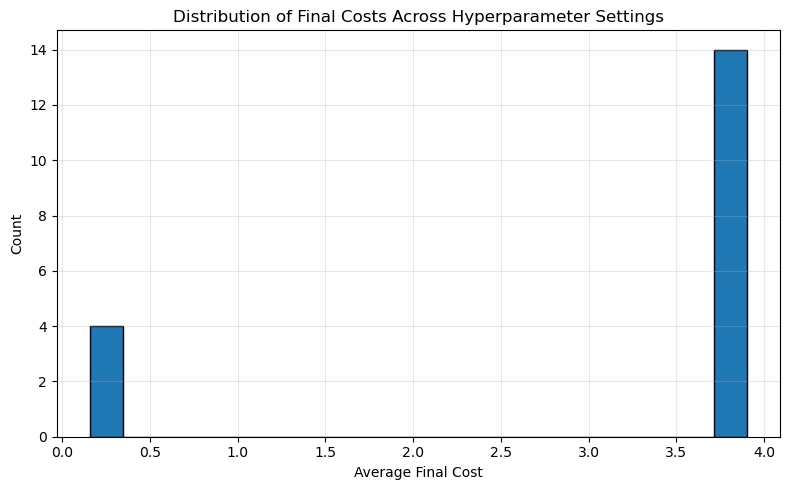

In [ ]:
# Optional: Load and analyze results
results_files = sorted(glob.glob(output_dir + 'abbr/*.pkl'))
print(f"Found {len(results_files)} result files")

if len(results_files) > 0:
    # Load all results
    results = []
    for f in results_files:
        with open(f, 'rb') as fp:
            results.append(dill.load(fp))
    
    # Extract hyperparameters and final costs
    hyperparams = []
    final_costs = []
    
    for r in results:
        if r.exception is None and r.best_costs is not None:
            hyperparams.append(r.modifier_values)
            # r.best_costs is shape (n_generations, n_configs)
            # Average across all configs for overall score
            final_costs.append(np.mean(r.best_costs[-1, :]))
    
    print(f"\nSuccessfully completed runs: {len(final_costs)}")
    if len(final_costs) > 0:
        print(f"Best average cost: {np.min(final_costs):.6f}")
        print(f"Worst average cost: {np.max(final_costs):.6f}")
        print(f"Mean average cost: {np.mean(final_costs):.6f}")
        print(f"Std average cost: {np.std(final_costs):.6f}")
        
        # Plot distribution of final costs
        plt.figure(figsize=(8, 5))
        plt.hist(final_costs, bins=20, edgecolor='black')
        plt.xlabel('Average Final Cost')
        plt.ylabel('Count')
        plt.title('Distribution of Final Costs Across Hyperparameter Settings')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
